In [1]:
from pathlib import Path

In [2]:
example = Path.cwd()
project = Path.cwd().parent.parent
data = Path(f'{example}/frio.csv')

print(project)

c:\Users\kucharsk\dev\hydropattern


In [3]:
import sys
sys.path.append(str(project))

from hydropattern.timeseries import Timeseries
from hydropattern.parsers import timing_parser, magnitude_parser, duration_parser
from hydropattern.patterns import Component, evaluate_component

## Water year
My best guess is that the water year starts around March 1 in this location.

In this location water years are mostly contained in year in which it begins. Therefore, below I refer to water years according the calendar year in which they begin. For example, water year 2020 starts on March 1, 2020 and ends on February 28, 2021. *Note: this is the opposite of the USGS definition of water year, which starts in October in North America (i.e., for USGS water year 2020 starts on October 1, 2019)*

In [4]:
# clipping first 2 observations since they seems to be a "warm up" values.
df = Timeseries.from_csv(str(data), first_dowy=75).data[2:] # march 15th
ts = Timeseries.from_dataframe(df, first_dowy=75, path=str(data))
ts.data.head()

,q_river,dowy
time,,
2010-01-03,92.573456,294
2010-01-04,110.430695,295
2010-01-05,110.653010,296
2010-01-06,107.531624,297
2010-01-07,101.034010,298


## Hydrologic "modes"
The plot below is my best guess at how to classify various periods of flow, based on visual inspection of the hydrograph. These modes are:

1. **Drought hydrology**: 0 - 10 cms. This only occurs in the 2016 and 2019 calendar years.
2. **Dry season hydrology**: 10 - 100 cms. This actually captures a substaintial portion of the rising and falling limb of the hydrograph, from about beginning of January to mid April. *Note*: mid-Jan to mid-March looks like baseflow.
3. **Wet season hydrology**: 100 - 500 cms. This captures the bulk of the hydrograph from mid-April to end of December.
4. **"Flood" hydrology**: > 500 cms. These are short peaks that occur in multiple times most years (with the exception of 2017 and 2018 [calendar and water years]).  

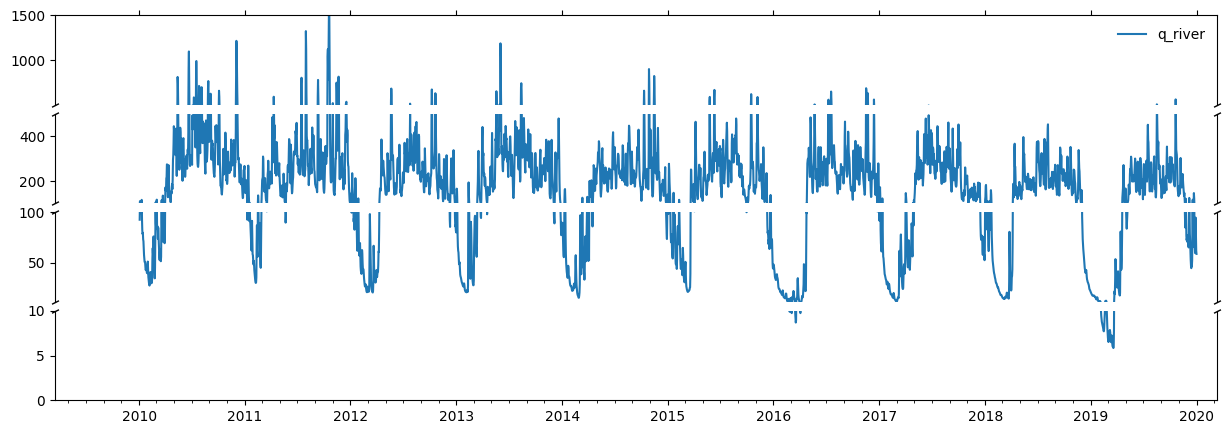

In [5]:
ts.plot_timeseries(broken_axis_ranges=[0, 10, 11, 100, 101, 500, 501, 1500],
                   output_path=f'{example}/frio_ts.png')

TODO: Add horizontal lines in hydrograph below to show hyrologic modes.

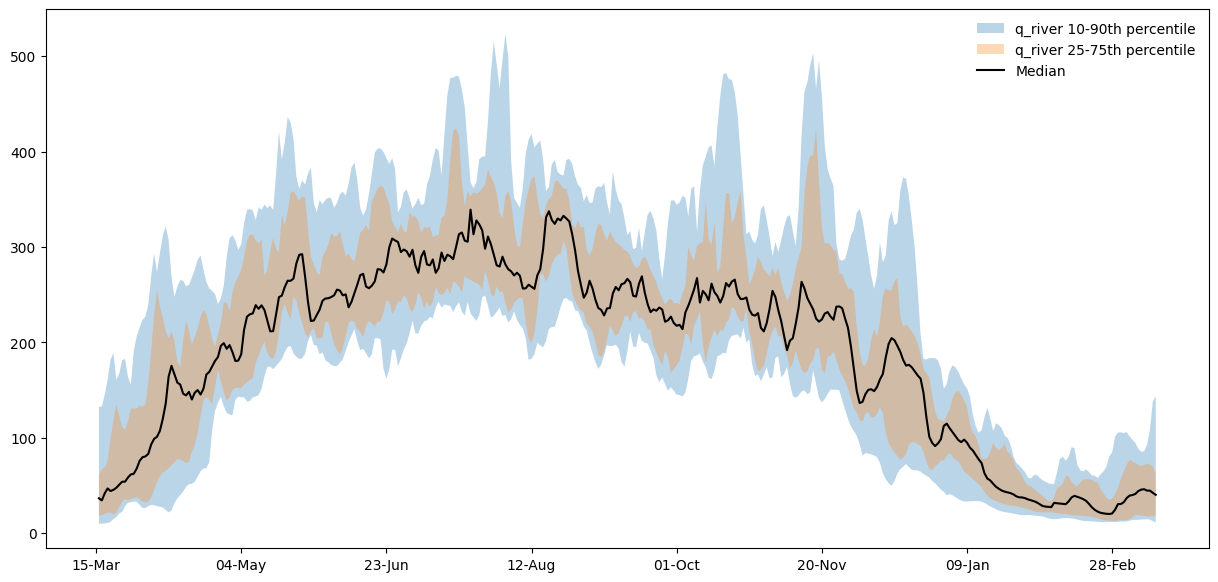

In [6]:
ts.plot_hydrograph_quantiles(rolling_periods=7, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                             output_path=f'{example}/frio_7d.png')

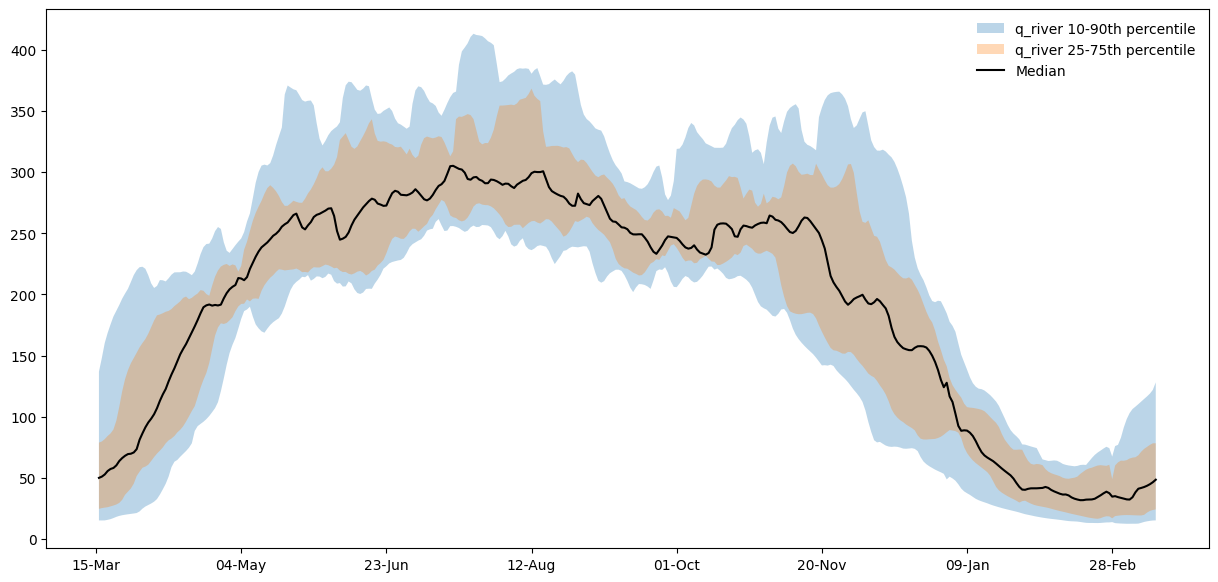

In [7]:
ts.plot_hydrograph_quantiles(rolling_periods=30, quantiles=[0.1, 0.25, 0.5, 0.75, 0.9],
                             output_path=f'{example}/frio_30d.png')

In [8]:
timing = timing_parser(
    metrics=[ts.month_day_year_to_day_of_water_year(month=1, day=1),
             ts.month_day_year_to_day_of_water_year(month=2, day=28)],
    order=1)                       # between 1 Jan and 28 Feb
magnitude = magnitude_parser(
    metrics=[10, 100],
    order=2)                       # flow between 10 and 100
duration = duration_parser(
    metrics=[">", 10],
    order=3)                       # for at least 10 days (time periods)
print(f'{timing}\n {magnitude}\n {duration}')

Characteristic(name='timing_292-350', fx=<function timing_fx.<locals>.closure at 0x000001F921E4BBA0>, type=<CharacteristicType.TIMING: 'timing'>)
 Characteristic(name='magnitude_10-100', fx=<function magnitude_fx.<locals>.closure at 0x000001F921FA6F20>, type=<CharacteristicType.MAGNITUDE: 'magnitude'>)
 Characteristic(name='duration_gt10', fx=<function duration_fx.<locals>.closure at 0x000001F921FA76A0>, type=<CharacteristicType.DURATION: 'duration'>)


In [9]:
first_migration = Component(name='first_migration', characteristics=[timing, magnitude, duration], is_success_pattern=True)
print(first_migration)

Component(name='first_migration', characteristics=[Characteristic(name='timing_292-350', fx=<function timing_fx.<locals>.closure at 0x000001F921E4BBA0>, type=<CharacteristicType.TIMING: 'timing'>), Characteristic(name='magnitude_10-100', fx=<function magnitude_fx.<locals>.closure at 0x000001F921FA6F20>, type=<CharacteristicType.MAGNITUDE: 'magnitude'>), Characteristic(name='duration_gt10', fx=<function duration_fx.<locals>.closure at 0x000001F921FA76A0>, type=<CharacteristicType.DURATION: 'duration'>)], is_success_pattern=True)


In [10]:
result = evaluate_component(ts.data, first_migration)
result.df.head()

,dv,dowy,timing_292-350,magnitude_10-100,duration_gt10,first_migration
time,,,,,,
2010-01-03,92.573456,294,1,1,0,0
2010-01-04,110.430695,295,1,0,0,0
2010-01-05,110.653010,296,1,0,0,0
2010-01-06,107.531624,297,1,0,0,0
2010-01-07,101.034010,298,1,0,0,0


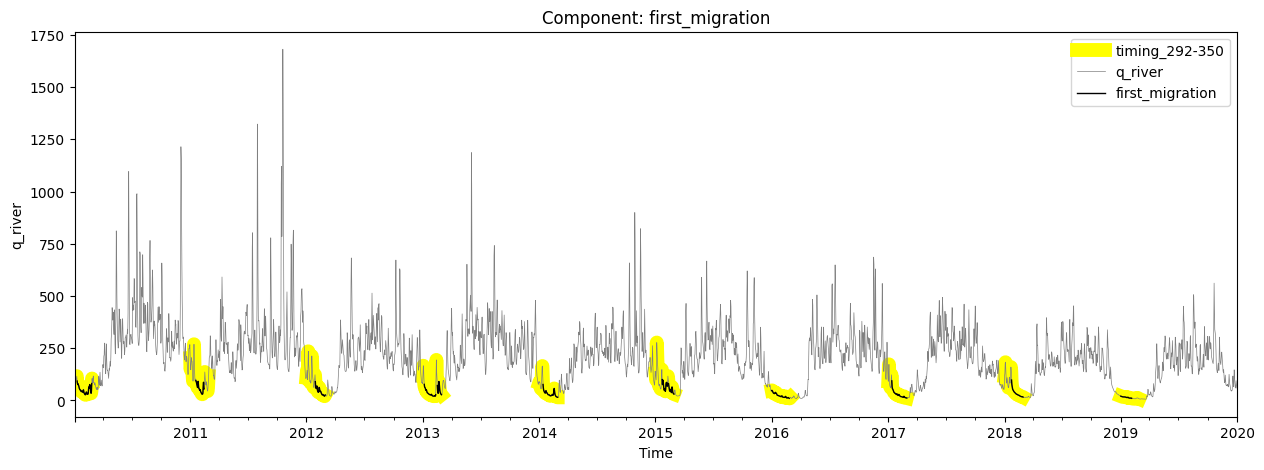

In [11]:
result.plot_success()

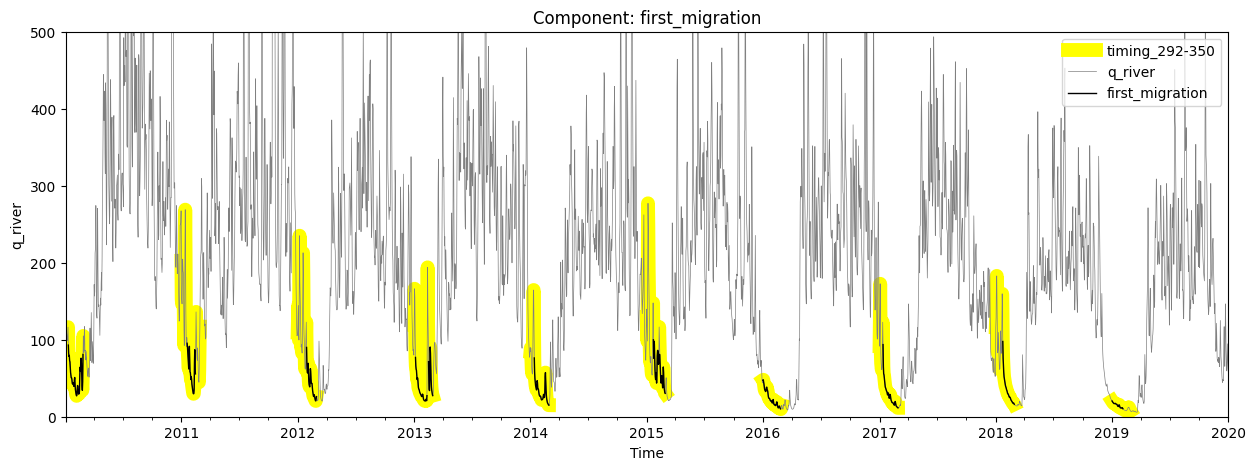

In [12]:
result.plot_success(ylimits=(0, 500))

In [13]:
df_freq = result.frequency_table(by_water_years=True)

In [14]:
df_round_freq = df_freq.round(decimals=0)
df_round_freq.head(len(df_freq))

,T,timing_292-350,timing_292-350(%),magnitude_10-100,magnitude_10-100(%),duration_gt10,duration_gt10(%),first_migration,first_migration(%)
total,3651,591,16.0,489,13.0,416,11.0,416,11.0
2010,363,57,16.0,50,14.0,47,13.0,47,13.0
2011,365,59,16.0,40,11.0,27,7.0,27,7.0
2012,366,60,16.0,42,11.0,32,9.0,32,9.0
2013,365,59,16.0,51,14.0,51,14.0,51,14.0
2014,365,59,16.0,55,15.0,47,13.0,47,13.0
2015,365,59,16.0,47,13.0,36,10.0,36,10.0
2016,366,60,16.0,59,16.0,56,15.0,56,15.0
2017,365,59,16.0,55,15.0,48,13.0,48,13.0
2018,365,59,16.0,48,13.0,37,10.0,37,10.0


Text(0.5, 1.0, 'First Migration Frequency Heatmap')

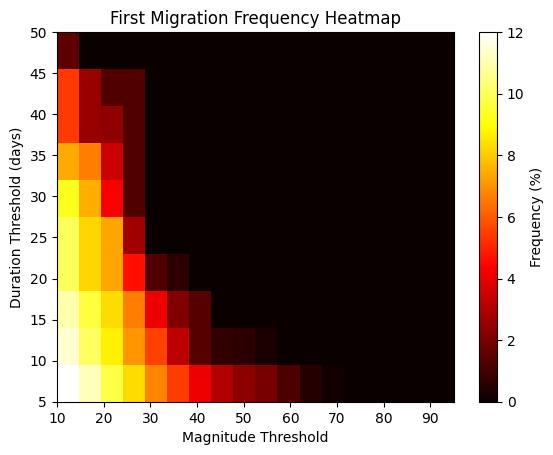

In [25]:

import numpy as np
import matplotlib.pyplot as plt
durations = [x for x in range(5, 51, 5)]
magnitudes = [x for x in range(10, 100, 5)]
# durations = np.arange(5, 50, 5)
# magnitudes = np.arange(10, 100, 5)
frequencies = np.zeros((len(durations), len(magnitudes)))
first_migrations = []
for i in range(len(durations)):
    for j in range(len(magnitudes)):
        timing = timing_parser(
            metrics=[ts.month_day_year_to_day_of_water_year(month=1, day=1),
                     ts.month_day_year_to_day_of_water_year(month=2, day=28)],
            order=1)                       # between 1 Jan and 28 Feb
        magnitude = magnitude_parser(
            metrics=[magnitudes[j], 100],
            order=2)                       # flow between 10 and current magnitude
        duration = duration_parser(
            metrics=[">", durations[i]],
            order=3)                       # for at least current duration (time periods)
        first_migration = Component(name='first_migration', characteristics=[timing, magnitude, duration], is_success_pattern=True)
        result = evaluate_component(ts.data, first_migration)
        df_freq = result.frequency_table(by_water_years=False)
        frequencies[i, j] = df_freq[f'{first_migration.name}(%)'].values[0]
        first_migrations.append(first_migration)
# use imshow to plot the heatmap with color bar
plt.imshow(frequencies, cmap='hot', interpolation='nearest', origin='lower',
           extent=[magnitudes[0], magnitudes[-1], durations[0], durations[-1]],
           aspect='auto', vmin=0, vmax=12)
plt.colorbar(label='Frequency (%)')
plt.xlabel('Magnitude Threshold')
plt.ylabel('Duration Threshold (days)')
plt.title('First Migration Frequency Heatmap')